# Aula de Demonstração Prática

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn import svm
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import feature_selection

In [2]:
# Constantes geralmente ficam no inicio do notebook e usam apenas letras maiusculas

# Caminho do arquivo de entrada
INPUT_FILEPATH = "weatherAUS.csv"

# Variavel que queremos predizer
TARGET = "RainTomorrow"

# Tamanho do conjunto de validacao (proporcao)
VAL_SIZE = 0.2

# Numero de features a serem usadas
N_FEATURES = 20

## Resumo dos Dados

O conjunto de dados usado neste notebook consiste observações meteorologicas diárias feitas em múltiplas cidades Australianas. O problema abordado é de classificar, a partir de medições feitas no dia atual, se haverá chuva no dia seguinte. 

Fonte dos dados: [Kaggle: Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)

In [3]:
# Leitura do dataset para um DataFrame do Pandas
# (neste caso ele usa o separador default que eh a virgula)
df = pd.read_csv(INPUT_FILEPATH)

# Remove colunas que nao serao usadas
df = df.drop(["Date", "Location", "RISK_MM"], axis=1)

# Imprime algumas informacoes basicas sobre os dados
print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))
print("Dados faltando: {}".format(df.isnull().sum().sum()))

print("\nAmostra:")
with pd.option_context("max_columns", 12): # Limita o numero de cols mostradas
    display(df.head(20))

# Cria uma lista com as features
features = list(df.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))

mpl.rc('font', size=14)

Numero de linhas: 142193
Numero de colunas: 21
Dados faltando: 316559

Amostra:


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,...,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,WNW,...,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,WSW,...,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,NE,...,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,W,...,7.0,8.0,17.8,29.7,No,No
5,14.6,29.7,0.2,NaN,NaN,WNW,...,NaN,NaN,20.6,28.9,No,No
6,14.3,25.0,0.0,NaN,NaN,W,...,1.0,NaN,18.1,24.6,No,No
7,7.7,26.7,0.0,NaN,NaN,W,...,NaN,NaN,16.3,25.5,No,No
8,9.7,31.9,0.0,NaN,NaN,NNW,...,NaN,NaN,18.3,30.2,No,Yes
9,13.1,30.1,1.4,NaN,NaN,W,...,NaN,NaN,20.1,28.2,Yes,No


Target: RainTomorrow
Features:
  MinTemp
  MaxTemp
  Rainfall
  Evaporation
  Sunshine
  WindGustDir
  WindGustSpeed
  WindDir9am
  WindDir3pm
  WindSpeed9am
  WindSpeed3pm
  Humidity9am
  Humidity3pm
  Pressure9am
  Pressure3pm
  Cloud9am
  Cloud3pm
  Temp9am
  Temp3pm
  RainToday


## Dados Faltando

In [4]:
df.isnull().sum().to_frame("Dados faltando").join(
    (df.isnull().sum().to_frame("%")*100/len(df)).round(2))

,Dados faltando,%
MinTemp,637,0.45
MaxTemp,322,0.23
Rainfall,1406,0.99
Evaporation,60843,42.79
Sunshine,67816,47.69
WindGustDir,9330,6.56
WindGustSpeed,9270,6.52
WindDir9am,10013,7.04
WindDir3pm,3778,2.66
WindSpeed9am,1348,0.95


In [5]:
# Remove colunas com mais de 30% dos dados faltando
to_drop = ["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"]

df = df.drop(to_drop, axis=1)
print("Features removidas: {}".format(len(to_drop)))
print("\n".join(["  " + x for x in to_drop]))

# Remove linhas com dados faltando
n_before = df.shape[0]
df = df.dropna(axis=0, how="any")
print("\nLinhas removidas: {}".format(n_before - df.shape[0]))

# Certifica que nao ha mais dados faltando
assert df.isnull().sum().sum() == 0

# Reindexa as linhas
df = df.reset_index(drop=True)

Features removidas: 4
  Evaporation
  Sunshine
  Cloud9am
  Cloud3pm

Linhas removidas: 29268


## Análise Exploratória

Vamos primeiro visualizar rapidamente os dados para entender melhor o significado das features e verificar a existência de outliers ou outros possíveis problemas.

In [6]:
# Colunas com dados categoricos
cat_cols = ["RainToday", "WindGustDir", "WindDir9am", "WindDir3pm"]

# Colunas com dados numericos (reais)
real_cols = ["Humidity3pm", "Humidity9am", "MaxTemp",
             "MinTemp", "Pressure3pm", "Pressure9am", 
             "Rainfall", "Temp3pm", "Temp9am", 
             "WindGustSpeed", "WindSpeed3pm", "WindSpeed9am"]

### Features Categoricas

In [7]:
for c in cat_cols:
    display((df[c].value_counts().sort_index()/len(df)*100).round(2).to_frame(c +" (%)").T)

,No,Yes
RainToday (%),77.53,22.47


,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
WindGustDir (%),6.94,5.99,5.51,6.8,5.36,4.86,4.63,5.67,6.84,7.16,6.84,6.53,6.71,7.42,5.97,6.76


,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
WindDir9am (%),7.07,6.07,5.87,8.69,5.65,6.15,5.8,5.86,6.66,6.93,7.19,5.54,6.18,5.85,5.3,5.18


,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
WindDir3pm (%),5.95,5.78,6.08,6.38,5.86,4.69,5.37,5.65,7.2,7.37,6.9,5.92,6.78,7.04,6.14,6.88


### Features Numéricas

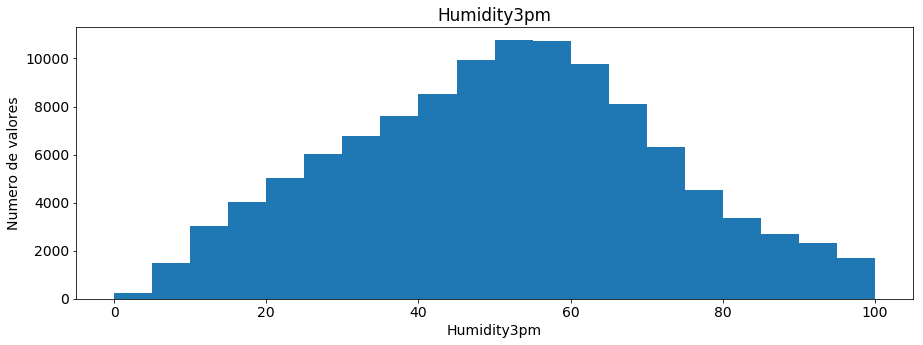

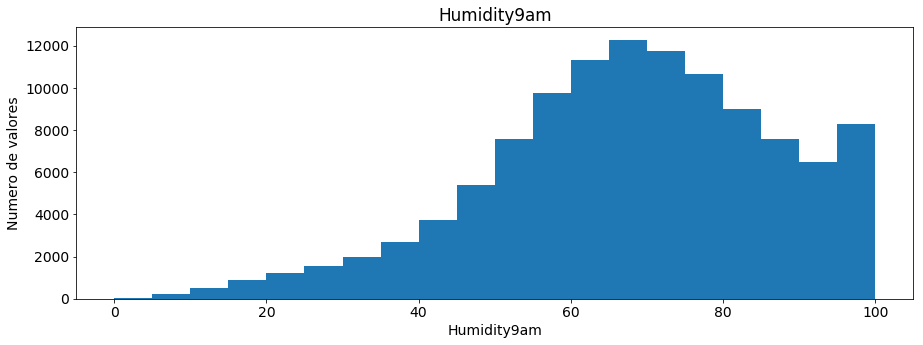

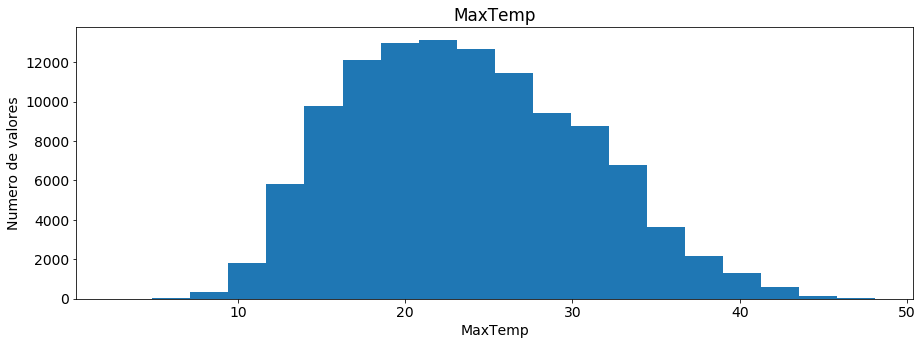

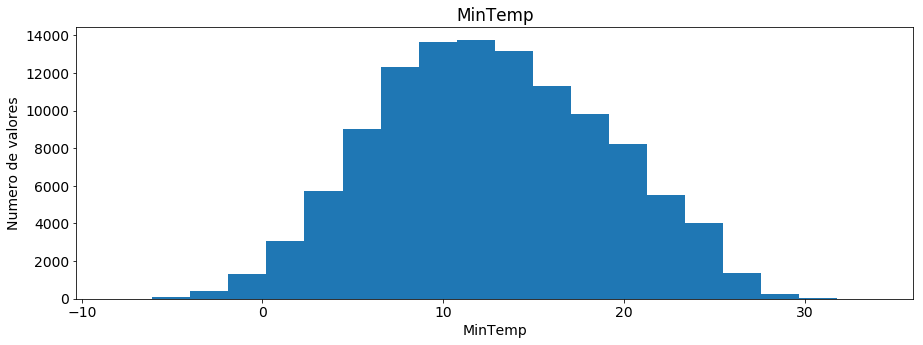

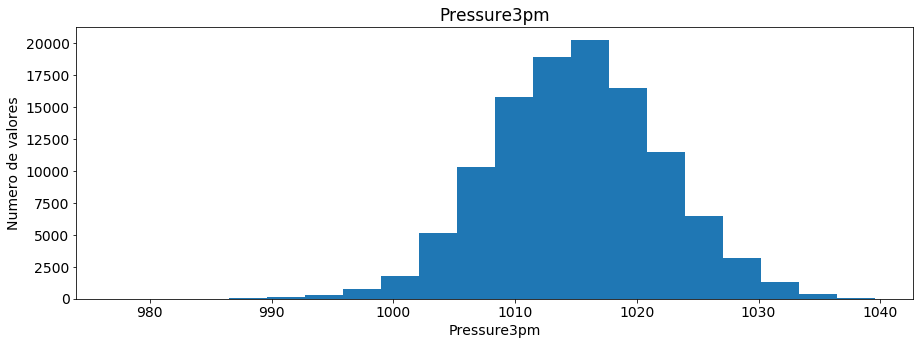

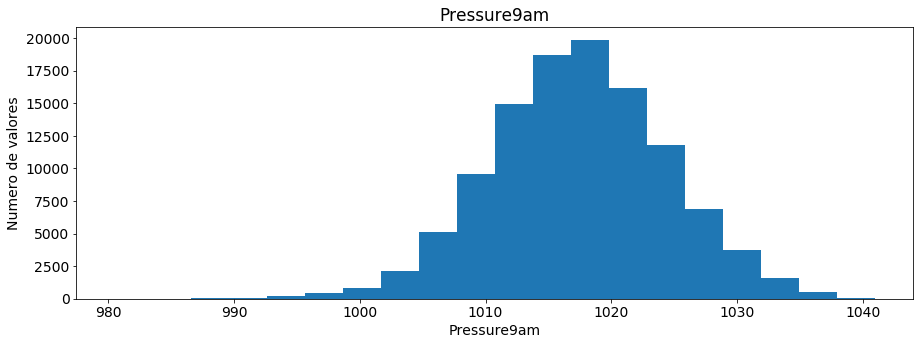

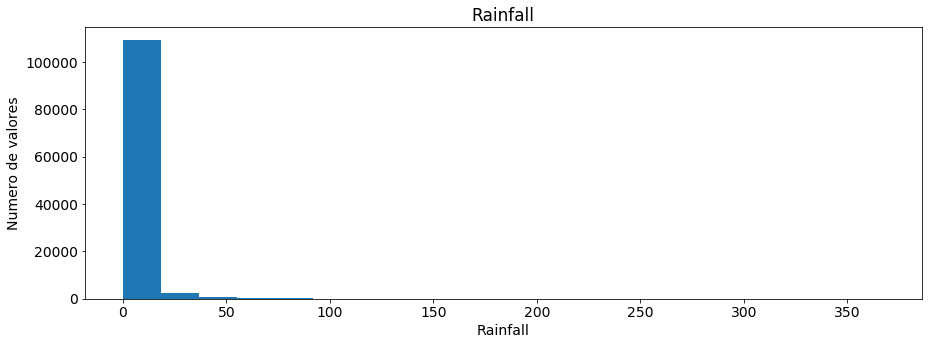

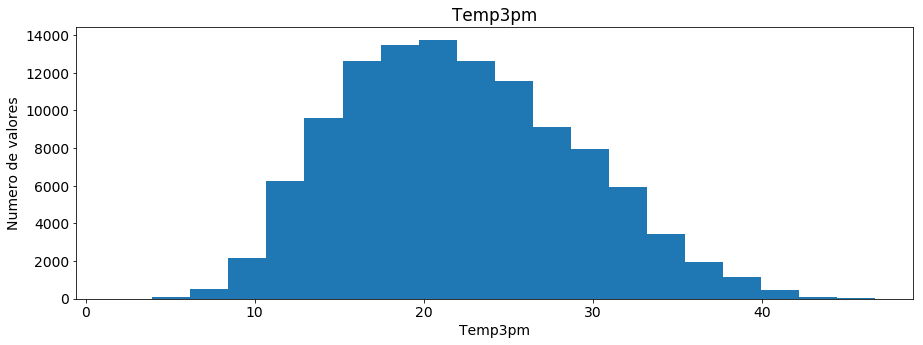

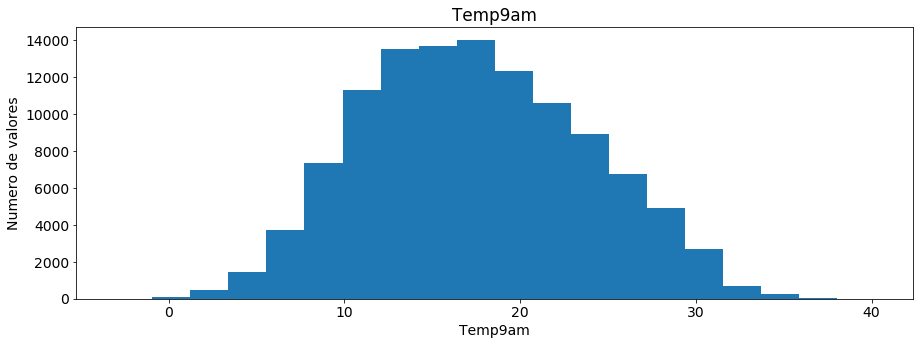

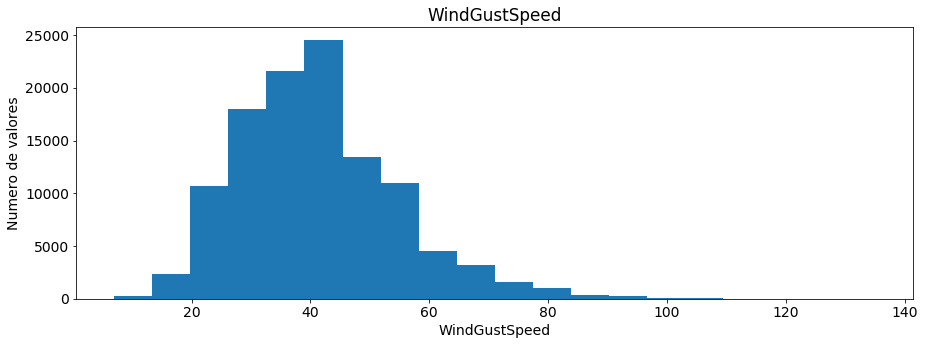

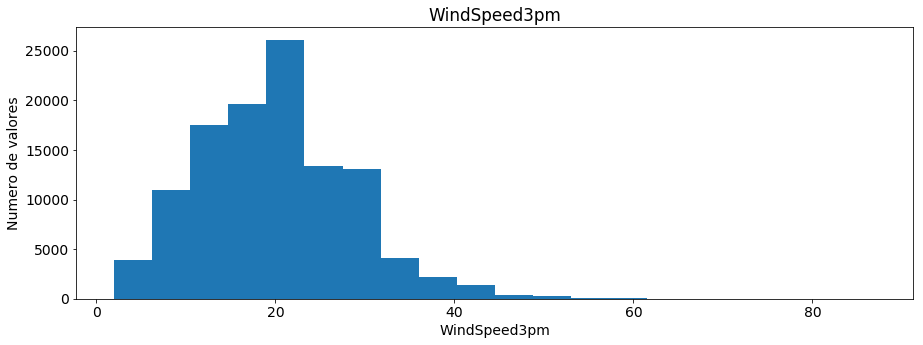

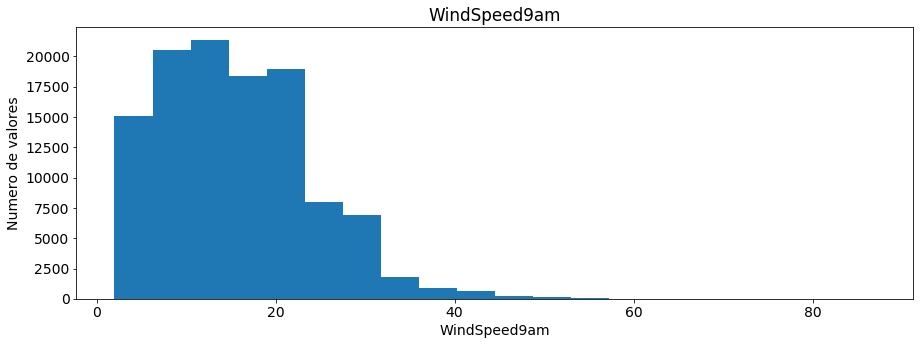

In [8]:
for c in real_cols:
    plt.figure(figsize=(15, 5))
    plt.hist(df[c], bins=20)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Numero de valores")
    plt.show()

### Target

Exibe a proporção de exemplos em cada classe.

In [9]:
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

,No,Yes
RainTomorrow (%),77.84,22.16


## Preprocessamento

### Dados Categóricos

In [10]:
# One-hot encoding para as features categoricas

# Cada valor da feature passa a ser uma coluna, 
# onde 1 indica que a linha tem aquele valor para 
# aquela feature, 0 caso contrario.
# Apenas N-1 dos N valores precisam ser codificados,
# pois o valor restante é representado por 0 nas outras colunas
for c in cat_cols:
    dfs_c = [(df[c] == val).astype(int).to_frame("{}_{}".format(c, val)) 
             for val in df[c].unique()[:-1]]
    
    df = pd.concat(dfs_c + [df], axis=1).drop(c, axis=1)

print("Exemplo de resultado para {}:\n".format(cat_cols[1]))
with pd.option_context("max_columns", 7):
    display(df[[x for x in df.columns if x.startswith(cat_cols[1])]].head())

Exemplo de resultado para WindGustDir:



,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,...,WindGustDir_SE,WindGustDir_ESE,WindGustDir_E
0,1,0,0,...,0,0,0
1,0,1,0,...,0,0,0
2,0,0,1,...,0,0,0
3,0,0,0,...,0,0,0
4,1,0,0,...,0,0,0


### Target

In [11]:
df[TARGET] = (df[TARGET] == "Yes").astype(int)

print("Resultado:")

display(df[[TARGET]].sample(10))

Resultado:


,RainTomorrow
100674,1
27420,1
104440,1
27793,0
91973,0
32027,0
56105,0
100425,0
77284,0
66338,0


### Normalização

In [12]:
# Recria a lista com as features
features = list(df.columns)
features.remove(TARGET)

# Subtrai a media
df[features] = df[features] - df[features].mean()

# Divide pelo desvio padrão
# (deve se tomar cuidado quando o desvio padrao 
# eh proximo de 0, aqui nao foi o caso)
df[features] = df[features] / df[features].std()

print("Resultado:")
df_mean = df[features].mean().round(2).to_frame("Media")
df_std = df[features].std().round(2).to_frame("Std")
with pd.option_context("max_rows", 15):
    display(df_mean.join(df_std))

Resultado:


,Media,Std
WindDir3pm_WNW,-0.0,1.0
WindDir3pm_WSW,0.0,1.0
WindDir3pm_E,-0.0,1.0
WindDir3pm_NW,-0.0,1.0
WindDir3pm_W,0.0,1.0
WindDir3pm_SSE,-0.0,1.0
WindDir3pm_ESE,-0.0,1.0
...,...,...
WindSpeed3pm,-0.0,1.0
Humidity9am,0.0,1.0


### Seleção de Features

In [13]:
# Utiliza Analysis of Variance (ANOVA) para selecionar features
# Cria um objeto skb que é usado posteriormente
skb = feature_selection.SelectKBest(feature_selection.f_classif, N_FEATURES)
skb = skb.fit(df[features], df[TARGET])

## Separação em Treino e Validação

In [14]:
# Retira uma amostra do dataset para rodar os experimentos rapido
df = df.sample(20000, replace=False, random_state=1)

idx = list(df.index)

np.random.shuffle(idx)

train_idx = idx[int(VAL_SIZE*len(idx)):]
val_idx = idx[:int(VAL_SIZE*len(idx))]

x_train = skb.transform(df.loc[train_idx, features])
x_val = skb.transform(df.loc[val_idx, features])
y_train = df.loc[train_idx, TARGET]
y_val = df.loc[val_idx, TARGET]

## Classificação

### k-Nearest Neighbors

In [15]:
# Define uma funcao que recebe o numero k de vizinhos,
# treina o modelo e mostra os resultados
def test_knn(k):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)

    clf = clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    val_acc = clf.score(x_val, y_val)

    print("K = {}".format(k))
    print("Acuracia de treino: {:.3}".format(train_acc))
    print("Acuracia de validação: {:.3}".format(val_acc))

In [16]:
test_knn(5)

K = 5
Acuracia de treino: 0.87
Acuracia de validação: 0.82


In [17]:
test_knn(10)

K = 10
Acuracia de treino: 0.851
Acuracia de validação: 0.828


In [18]:
test_knn(20)

K = 20
Acuracia de treino: 0.844
Acuracia de validação: 0.83


### Support Vector Machine

In [19]:
def test_svm_linear(C):
    clf = svm.SVC(C, "linear")

    clf = clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    val_acc = clf.score(x_val, y_val)

    print("C = {}".format(C))
    print("Acuracia de treino: {:.3}".format(train_acc))
    print("Acuracia de validação: {:.3}".format(val_acc))

In [20]:
test_svm_linear(0.01)

C = 0.01
Acuracia de treino: 0.848
Acuracia de validação: 0.846


In [21]:
test_svm_linear(0.1)

C = 0.1
Acuracia de treino: 0.848
Acuracia de validação: 0.85


In [22]:
test_svm_linear(1.0)

C = 1.0
Acuracia de treino: 0.849
Acuracia de validação: 0.851


### Adaboost

In [23]:
def test_adaboost(N):
    clf = ensemble.AdaBoostClassifier(n_estimators=N)

    clf = clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    val_acc = clf.score(x_val, y_val)

    print("N = {}".format(N))
    print("Acuracia de treino: {:.3}".format(train_acc))
    print("Acuracia de validação: {:.3}".format(val_acc))

In [24]:
test_adaboost(10)

N = 10
Acuracia de treino: 0.837
Acuracia de validação: 0.838


In [25]:
test_adaboost(50)

N = 50
Acuracia de treino: 0.85
Acuracia de validação: 0.845


In [26]:
test_adaboost(100)

N = 100
Acuracia de treino: 0.853
Acuracia de validação: 0.845


### Random Forest

In [27]:
def test_rf(N, max_depth):
    clf = ensemble.RandomForestClassifier(n_estimators=N, max_depth=max_depth)

    clf = clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    val_acc = clf.score(x_val, y_val)

    print("N = {}".format(N))
    print("Acuracia de treino: {:.3}".format(train_acc))
    print("Acuracia de validação: {:.3}".format(val_acc))

In [28]:
test_rf(50, None)

N = 50
Acuracia de treino: 0.999
Acuracia de validação: 0.852


In [29]:
test_rf(50, 5)

N = 50
Acuracia de treino: 0.848
Acuracia de validação: 0.839


In [30]:
test_rf(50, 3)

N = 50
Acuracia de treino: 0.826
Acuracia de validação: 0.826


In [31]:
test_rf(100, 5)

N = 100
Acuracia de treino: 0.847
Acuracia de validação: 0.836


In [32]:
test_rf(200, 5)

N = 200
Acuracia de treino: 0.846
Acuracia de validação: 0.838


### Avaliação do Modelo

In [33]:
# Vamos usar o Adaboost como exemplo
clf = ensemble.AdaBoostClassifier(n_estimators=50)

clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)
y_proba = clf.predict_proba(x_val)[:, 1]
classes = ["No", "Yes"]

In [34]:
print(metrics.classification_report(y_val, y_pred, [0, 1], classes))

              precision    recall  f1-score   support

          No       0.87      0.94      0.90      3119
         Yes       0.70      0.51      0.59       881

   micro avg       0.84      0.84      0.84      4000
   macro avg       0.79      0.72      0.75      4000
weighted avg       0.83      0.84      0.83      4000



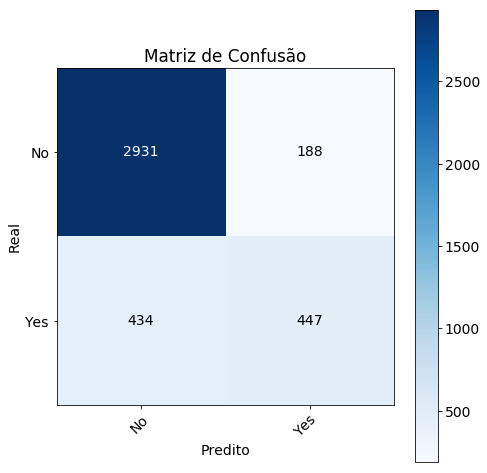

In [35]:
# Matriz de Confusao
cm = metrics.confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title="Matriz de Confusão",
       ylabel="Real",
       xlabel="Predito")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

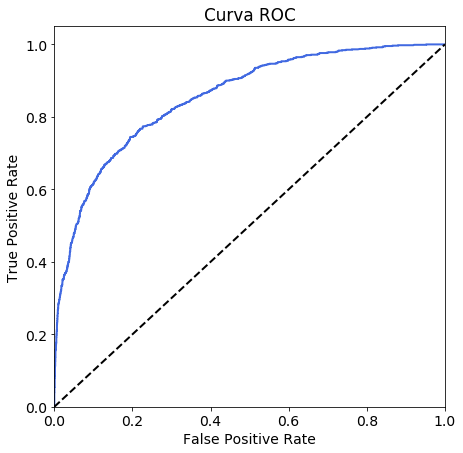

In [36]:
fpr, tpr, _ = metrics.roc_curve(y_val, y_proba)

plt.figure(figsize=(7, 7))
lw = 2
plt.plot(fpr, tpr, color='royalblue',lw=2)
plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.show()